# Computer Vision Workshop Notebook 1: Build and Deploy a Model

For this workshop, let's pretend that you work for a retail store.  You have developed a model that scans images and predicts what items are on a shelf, shopping card, or otherwise.

In this set of exercises, you will build to recognize images and deploy it to Wallaroo.

Before we start, let's load some libraries that we will need for this notebook (note that this may not be a complete list).

* **IMPORTANT NOTE**:  This tutorial is geared towards a Wallaroo 2023.2.1 environment.

In [21]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)
from wallaroo.framework import Framework

import json

import datetime
import time

# used for unique connection names

import string
import random

import pyarrow as pa

import sys
 
# setting path - only needed when running this from the `with-code` folder.
# sys.path.append('../')

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "../models/coco_classes.pickle"


<hr/>

#### Exercise: Build a model

The following models are examples of computer vision models that have been tested in Wallaroo.

* [RESNET50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html)
* [Mobilenet](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

Models similar to these can be deployed and deployed in Wallaroo.  It is recommended to convert them to the ONNX ML Model framework before deploying to Wallaroo.  Instructions for converting them are included with in the N0-environment-prep-model-conversion notebook.

**NOTE**

If you prefer to shortcut this step, you can use one of the pre-trained models.  These are available either through the Wallaroo Tutorials repository at https://github.com/WallarooLabs/Wallaroo_Tutorials/releases by selecting the most recent version and downloading `computer_vision.zip`, or by using the following command with the `gcloud` application:

```bash
gcloud storage cp "gs://wallaroo-model-zoo/open-source/computer-vision/models/*" .
```

It is highly recommended that these pre-trained models are stored in the `./models` folder.

In [3]:
## Blank space for training model, if needed




## Getting Ready to deploy

Wallaroo natively supports models in the ONNX, Python based models, Tensorflow frameworks, and other frameworks via containerization. For this exercise, we assume that you have a model that can be converted to the ONNX framework. The first steps to deploying in Wallaroo, then, is to convert your model to ONNX, and to add some extra functions to your processing modules so Wallaroo can call them.

For computer vision models, additional instructions are available in the N0-environment-prep-model-conversion notebook. 

<hr/>

#### Exercise: Convert your Model to ONNX

Take the model that you created in the previous exercises, and convert it to ONNX supported by Wallaroo. If you need help, see the [Wallaroo ONNX conversion tips](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-onnx/#onnx-conversion-tips).  The model can also be deployed to Wallaroo if is supported by Wallaroo.  See the [Wallaroo SDK Essentials Guide: Model Uploads and Registrations](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/)

At the end of this exercise, you should have your model as a standalone artifact, for example, a file called `model.onnx`.

**NOTE**

If you prefer to shortcut this exercise, one of the two ONNX models in the `./models` directory.

In [4]:
# Blank space to load for converting model, if needed




## Get ready to work with Wallaroo

Now that you have a model ready to go, you can log into Wallaroo and set up a **workspace** to organize your deployment artifacts. A Wallaroo workspace is place to organize the deployment artifacts for a project, and to collaborate with other team members. For more information, see [the Wallaroo 101](https://docs.wallaroo.ai/wallaroo-101/). 


Logging into Wallaroo via the cluster's integrated JupyterLab is quite straightfoward:

```python
# Login through local Wallaroo instance 
wl = wallaroo.Client()
```
See [the documentation](https://docs.wallaroo.ai/wallaroo-101/#connect-to-the-wallaroo-instance) if you are logging into Wallaroo some other way.

Once you are logged in, you can create a workspace and set it as your working environment. To make the first exercise easier, here is a convenience function to get or create a workspace:

In [2]:
# return the workspace called <name>, or create it if it does not exist.
# this function assumes your connection to wallaroo is called wl
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

Then logging in and creating a workspace looks something like this:

```python
# Login through local Wallaroo instance 
wl = wallaroo.Client()
```

Setting up the workspace may resemble this.  Verify that the workspace name is unique across the Wallaroo instance.

```python
# workspace names need to be globally unique, so add a random suffix to insure this
# especially important if the "main" workspace name is potentially a common one

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))
workspace_name = "my-workspace"+suffix

workspace = get_workspace(workspace_name)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

```

<hr/>

#### Exercise: Log in and create a workspace

Log into wallaroo, and create a workspace for this workshop. Then set that new workspace to your current workspace.
Make sure you remember the name that you gave the workspace, as you will need it for later notebooks. Set that workspace to be your working environment.

**Notes**
* Workspace names must be globally unique, so don't pick something too common. The "random suffix" trick in the code snippet is one way to try to generate a unique workspace name, if you suspect you are using a common name. 

At the end of the exercise, you should be in a new workspace to do further work.


In [ ]:
## Blank spot to log in

wl = wallaroo.Client()

In [4]:
## Blank spot to connect to the workspace

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

workspace_name = f'computer-vision-workshop'

workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)


{'name': 'computer-vision-workshopjohn', 'id': 20, 'archived': False, 'created_by': '0a36fba2-ad42-441b-9a8c-bac8c68d13fa', 'created_at': '2023-08-04T19:16:04.283819+00:00', 'models': [], 'pipelines': []}

## Deploy a Simple Single-Step Pipeline

Once your model is in the ONNX format, and you have a workspace to work in, you can easily upload your model to Wallaroo's production platform with just a few lines of code. For example, if you have a model called `model.onnx`, and you wish to upload it to Wallaroo with the name `mymodel`, then upload the model as follows (once you are in the appropriate workspace):

```python
my_model = wl.upload_model("mymodel", "model.onnx", framework=Framework.ONNX).configure('onnx', batch_config="single")
```

The addition of `.configure('onnx', batch_config="single")` is used for these computer vision models to instruct Wallaroo how to handle the inputs.

See [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: ONNX](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-onnx/) for full details.

The function `upload_model()` returns a handle to the uploaded model that you will continue to work with in the SDK.

### Upload Python Models

For this tutorial, we also recommend the use of the Python step model `./models/post-process-drift-detection-arrow.py`.  This takes the output of the models and averages the confidence values into one value `avg_conf`.  This value is necessary for performing observations for data validation and Wallaroo assays.

To upload a Python model to Wallaroo, the following is required:

* The name of the model:  What to designate the model name once uploaded to Wallaroo.
* Path of the Python script:  This specifies the file location.  For example: `./models/my-python-script.py`
* The input and output schemas:  These inform Wallaroo how inference request data will be formatted, and the shape of the data going out from the model.  The schema is in Apache Arrow schema format, aka `pyarrow.lib.Schema`..  These are required to be in the For example, if the inference inputs are a pandas DataFrame with the following shape:

| &nbsp; | tensor |
|---|---|
| 0 | [15.5, 17.2, 35.724, 0.37894 ]

With the following output:

[
    "forecast": [235, 135, 175],
    "average_forecast": [181.66]
]

In this case, the input schema is represented as:

```python
import pyarrow as py

input_schema = pa.schema([
    pa.field('tensor', pa.list_(pa.float64()))
])

output_schema = pa.schema([
    pa.field('forecast', pa.list_(pa.int64())),
    pa.field('average_forecast', pa.list_(pa.float64()))
])
```

Python models are uploaded to Wallaroo with the `upload_model` method, with the additional `configure` method specifying the `python` framework with the inputs and outputs.  For example:

```python
sample_model = (wl.upload_model(control_model_name, 
                                 control_model_file, 
                                 framework=Framework.PYTHON)
                                 .configure("python", 
                                 input_schema=input_schema, 
                                 output_schema=output_schema)
                )
```

For more information about Python models, see [Wallaroo SDK Essentials Guide: Model Uploads and Registrations: Python Models](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-model-uploads/wallaroo-sdk-model-upload-python/).

Once the model has been uploaded, you can create a **pipeline** that contains the model. The pipeline is the mechanism that manages deployments. A pipeline contains a series of **steps** - sequential sets of models which take in the data from the preceding step, process it through the model, then return a result. Some pipelines can have just one step, while others may have multiple models with multiple steps or arranged for A/B testing. Deployed pipelines allocate resources and can then process data either through local files or through a **deployment URL**.

So for your model to accept inferences, you must add it to a pipeline. You can create a single step pipeline called `mypipeline` as follows.

```python
# create the pipeline
my_pipeline = wl.build_pipeline("mypipeline").add_model_step(my_model)

# deploy the pipeline
my_pipeline = my_pipeline.deploy()
```

Multiple steps can be deployed to the same pipeline.  The data from each previous step is passed to the next.  To use the post process Python step provided, we can apply both model and post process step as follows:

```python
# create the pipeline
my_pipeline = wl.build_pipeline("mypipeline")
my_pipeline.add_model_step(my_model)
my_pipeline.add_model_step(postprocessing-step)

# deploy the pipeline
my_pipeline = my_pipeline.deploy()
```

This pipeline now has two steps.  If using our example Python step, the difference is the model returns the fields `boxes`, `classes`, and `confidences`, each as an array of values.  The python step takes that data and adds the additional field `avg_conf`, which is an average of the `confidences` fields.

Deploying the pipeline means that resources from the cluster are allocated to the pipeline, and it is ready to accept inferences. You can "turn off" the pipeline with the call `pipeline.undeploy()`, which returns the resources back to the cluster.  This is an important step - leaving pipeline deployed when they're no longer needed takes up resources that may be needed by other pipelines or services.

See [Wallaroo SDK Essentials Guide: Pipeline Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-pipelines/wallaroo-sdk-essentials-pipeline/) for full details.

**More Hints**

* `workspace = wl.get_current_workspace()` gives you a handle to the current workspace
* then `workspace.models()` will return a list of the models in the workspace
* and `workspace.pipelines()` will return a list of the pipelines in the workspace

<hr/>

#### Exercise: Upload and deploy your model

Upload and deploy the ONNX model that you created in the previous exercise. For simplicity, do any needed pre-processing in the notebook.

At the end of the exercise, you should have a model and a deployed pipeline in your workspace.

In [17]:
## blank space to upload model, and create the pipeline

mobilenet_model_name = 'mobilenet'
mobilenet_model_path = "../models/mobilenet.pt.onnx"

mobilenet_model = wl.upload_model(mobilenet_model_name, 
                                  mobilenet_model_path, 
                                  framework=Framework.ONNX).configure('onnx', 
                                                                      batch_config="single"
                                                                      )

# upload python step

field_boxes = pa.field('boxes', pa.list_(pa.list_(pa.float64(), 4)))
field_classes = pa.field('classes', pa.list_(pa.int32()))
field_confidences =  pa.field('confidences', pa.list_(pa.float64()))

# field_boxes - will have a flattened array of the 4 coordinates representing the boxes.  128 entries
# field_classes - will have 32 entries
# field_confidences - will have 32 entries
input_schema = pa.schema([field_boxes, field_classes, field_confidences])

output_schema = pa.schema([
    field_boxes,
    field_classes,
    field_confidences,
    pa.field('avg_conf', pa.list_(pa.float64()))
])

module_post_process = wl.upload_model("cv-post-process-drift-detection", 
                                      "../models/post-process-drift-detection-arrow.py",
                                      framework=Framework.PYTHON ).configure('python', 
                                                                             input_schema=input_schema, 
                                                                             output_schema=output_schema
                                    )

# create the pipeline

pipeline_name = 'cv-retail-pipeline'

pipeline = wl.build_pipeline(pipeline_name)
pipeline.undeploy()
pipeline.clear()
pipeline.add_model_step(mobilenet_model)
pipeline.add_model_step(module_post_process)
pipeline.deploy()



name,cv-retail-pipeline
created,2023-08-04 19:23:11.179176+00:00
last_updated,2023-08-04 19:43:05.131579+00:00
deployed,True
tags,
versions,"9eb22dbc-c035-4ac4-bba9-b7cd3a9f30ba, 5ce99fc6-4463-4ab0-abbe-8b490ce9fc29, 8faa0d21-11ed-4186-8f5d-a586ead7ab00, 305db319-db20-4be8-94a7-ecb3d8bee4d4, 15cc7825-03a1-4794-8a31-744d290db193"
steps,mobilenet


## Sending Data to your Pipeline

ONNX models generally expect their input as an array in a dictionary, keyed by input name. In Wallaroo, the default input name is "tensor". So (outside of Wallaroo), an ONNX model that expected three numeric values as its input would expect input data similar to the below: (**Note: The below examples are only notional, they aren't intended to work with our example models.**)

```python
# one datum
singleton = {'tensor': [[1, 2, 3]] }

# two datums
two_inputs = {'tensor': [[1, 2, 3], [4, 5, 6]] }
```

In the Wallaroo SDK, you can send a pandas DataFrame representation of this dictionary (pandas record format) to the pipeline, via the `pipeline.infer()` method.

```python
import pandas as pd

# one datum (notional example)
sdf = pd.DataFrame(singleton)
sdf
#       tensor
# 0  [1, 2, 3]

# send the datum to a pipeline for inference
# notional example - not houseprice model!
result = my_pipeline.infer(sdf)

# two datums
# Note that the value of 'tensor' must be a list, not a numpy array 
twodf = pd.DataFrame(two_inputs)
twodf
#      tensor
# 0  [1, 2, 3]
# 1  [4, 5, 6]

# send the data to a pipeline for inference
# notional example, not houseprice model!
result = my_pipeline.infer(twodf)
```

To send data to a pipeline via the inference URL (for example, via CURL), you need the JSON representation of these data frames.

```python
#
# notional examples, not houseprice model!
#
sdf.to_json(orient='records')
# '[{"tensor":[1,2,3]}]'

twodf.to_json(orient='records')
# '[{"tensor":[1,2,3]},{"tensor":[4,5,6]}]'
```

For these tutorials, images are converted into their `tensor` value using the `cvDemo.loadImageAndConvertToDataframe(image_path, width, height)`.  For example, the following converts the file `./data/images/input/example/dairy_bottles.png` into its tensor values.

```python
width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe('data/images/input/example/dairy_bottles.png', 
                                                              width, 
                                                              height
                                                              )
dfImage

	tensor
0	[[[[0.9372549 0.9529412 0.9490196 0.9450980...
```



<hr/>

#### Exercise: Send data to your pipeline for inference.

Create some test data from the housing data and send it to the pipeline that you deployed in the previous exercise.  

* If you used the pre-provided models, then you can use the images from the `./data/images/input/example` folder with the `cvDemo.loadImageAndConvertToDataframe` to translate it into a pandas DataFrame with the relevant tensor data.

At the end of the exercise, you should have a set of inference results that you got through the Wallaroo pipeline. 

In [23]:
##  blank space to create test data, and send some data to your model

image = '../data/images/input/example/dairy_bottles.png'

width, height = 640, 480
dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )

results = pipeline.infer(dfImage)
display(results)


,time,in.tensor,out.avg_conf,out.boxes,out.classes,out.confidences,check_failures
0,2023-08-04 19:54:24.984,"[0.9372549057, 0.9529411793, 0.9490196109, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9490196109, 0.9490196109, 0.9529411793, 0.9529411793, 0.9490196109, 0.9607843161, 0.9686274529, 0.9647058845, 0.9686274529, 0.9647058845, 0.9568627477, 0.9607843161, 0.9647058845, 0.9647058845, 0.9607843161, 0.9647058845, 0.9725490212, 0.9568627477, 0.9607843161, 0.9176470637, 0.9568627477, 0.9176470637, 0.8784313798, 0.8941176534, 0.8431372643, 0.8784313798, 0.8627451062, 0.850980401, 0.9254902005, 0.8470588326, 0.9686274529, 0.8941176534, 0.8196078539, 0.850980401, 0.9294117689, 0.8666666746, 0.8784313798, 0.8666666746, 0.9647058845, 0.9764705896, 0.980392158, 0.9764705896, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.9725490212, 0.980392158, 0.8941176534, 0.4823529422, 0.4627451003, 0.4313725531, 0.270588249, 0.2588235438, 0.2941176593, 0.3450980484, 0.3686274588, 0.4117647111, 0.4549019635, 0.4862745106, 0.5254902244, 0.5607843399, 0.6039215922, 0.6470588446, 0.6862745285, 0.721568644, 0.7450980544, 0.7490196228, 0.7882353067, 0.8666666746, 0.980392158, 0.9882352948, 0.9686274529, 0.9647058845, 0.9686274529, 0.9725490212, 0.9647058845, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, ...]",[0.2895053208114637],"[[0.0, 210.29010009765625, 85.26463317871094, 479.074951171875], [72.03781127929688, 197.32269287109375, 151.44223022460938, 468.4322509765625], [211.2801513671875, 184.72837829589844, 277.2192077636719, 420.4274597167969], [143.23904418945312, 203.83004760742188, 216.85546875, 448.8880920410156], [13.095015525817873, 41.91339111328125, 640.0, 480.0], [106.51464080810548, 206.14498901367188, 159.5464324951172, 463.9675598144531], [278.0636901855469, 1.521723747253418, 321.45782470703125, 93.56348419189452], [462.3183288574219, 104.16201782226562, 510.53961181640625, 224.75314331054688], [310.4559020996094, 1.395981788635254, 352.8512878417969, 94.1238250732422], [528.0485229492188, 268.4224853515625, 636.2671508789062, 475.7666015625], [220.06292724609375, 0.513851165771484, 258.3183288574219, 90.18019104003906], [552.8711547851562, 96.30235290527344, 600.7255859375, 233.53384399414065], [349.24072265625, 0.270343780517578, 404.1732482910156, 98.6802215576172], [450.8934631347656, 264.235595703125, 619.603271484375, 472.6517333984375], [261.51385498046875, 193.4335021972656, 307.17913818359375, 408.7524719238281], [509.2201843261719, 101.16539001464844, 544.1857299804688, 235.7373962402344], [592.482421875, 100.38687133789062, 633.7798461914062, 239.1343231201172], [475.5420837402344, 297.6141052246094, 551.0543823242188, 468.0154724121094], [368.81982421875, 163.61407470703125, 423.909423828125, 362.7887878417969], [120.66899871826172, 0.0, 175.9362030029297, 81.77457427978516], [72.48429107666016, 0.0, 143.5078887939453, 85.46980285644531], [271.1268615722656, 200.891845703125, 305.6260070800781, 274.5953674316406], [161.80728149414062, 0.0, 213.0830841064453, 85.42828369140625], [162.13323974609375, 0.0, 214.6081390380859, 83.81443786621094], [310.8910827636719, 190.9546813964844, 367.3292541503906, 397.2813720703125], [396.67083740234375, 166.49578857421875, 441.5286254882813, 360.07525634765625], [439.2252807617187, 256.26361083984375, 640.0, 473.165771484375], [544.5545654296875, 375.67974853515625, 636.8954467773438, 472.8069458007813], [272.79437255859375, 2.753482818603515, 306.8874206542969, 96.72763061523438], [453.7723388671875, 303.7969665527344, 524.5588989257812, 463.2135009765625], [609.8508911132812, 94.62291717529295, 635.7705078125, 211.13577270507812]]","[44, 44, 44, 44, 82, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 84, 84, 44, 84, 44, 44, 44, 61, 44, 86, 44, 44]","[0.98649001121521, 0.901153

### Render the Image

If using our sample models, this inference has returned the following fields:

* `out.boxes`: An array of the bounding boxes for detected objects.
* `out.classes`: Identifies the type of object detected.
* `out.confidences`: Displays the confidence level the model has in its classification.
* `out.avg_conf`: An average of all of the confidence values.

The provides `CVDemoUtils` contains a handy method `cvDemo.drawDetectedObjectsFromInference(results)` that takes these values and combines then with the images to show the bounding boxes of detected objects.  Not that `inf-results` requires the inference results derived earlier.

```python
elapsed = 1.0

sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : results,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)
```

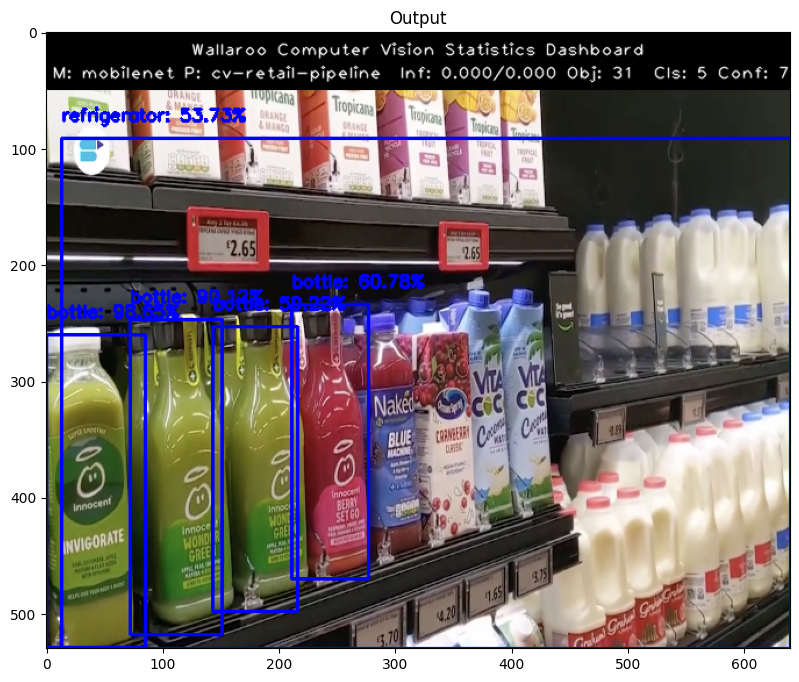

In [24]:


elapsed = 1.0

sample = {
    'model_name' : mobilenet_model_name ,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : results,
    'confidence-target' : 0.50,
    'inference-time': 0,
    'onnx-time' : int(elapsed) / 1e+9,                
    'color':(255,0,0)
}

image = cvDemo.drawDetectedObjectsFromInference(sample)

## Undeploying Your Pipeline

You should always undeploy your pipelines when you are done with them, or don't need them for a while. This releases the resources that the pipeline is using for other processes to use. You can always redeploy the pipeline when you need it again. As a reminder, here are the commands to deploy and undeploy a pipeline:

```python

# when the pipeline is deployed, it's ready to receive data and infer
pipeline.deploy()

# "turn off" the pipeline and releaase its resources
pipeline.undeploy()

```

If you are continuing on to the next notebook now, you can leave the pipeline deployed to keep working; but if you are taking a break, then you should undeploy.

In [25]:
## blank space to undeploy the pipeline, if needed

pipeline.undeploy()


name,cv-retail-pipeline
created,2023-08-04 19:23:11.179176+00:00
last_updated,2023-08-04 19:43:05.131579+00:00
deployed,False
tags,
versions,"9eb22dbc-c035-4ac4-bba9-b7cd3a9f30ba, 5ce99fc6-4463-4ab0-abbe-8b490ce9fc29, 8faa0d21-11ed-4186-8f5d-a586ead7ab00, 305db319-db20-4be8-94a7-ecb3d8bee4d4, 15cc7825-03a1-4794-8a31-744d290db193"
steps,mobilenet


## Congratulations!

You have now 

* Successfully trained a model
* Converted your model and uploaded it to Wallaroo
* Created and deployed a simple single-step pipeline
* Successfully send data to your pipeline for inference

In the next notebook, you will look at two different ways to evaluate your model against the real world environment.

